# Predict Electricity and Gas Utility Production
Build an RNN to predict energy production using the Federal Reserve Economic Database (FRED) Electricity and Gas Utilities Production dataset between Jan 1992 and Jan 2019

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Helps plot datetime vals with matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


### Import and explore data

In [2]:
df = pd.read_csv('../Data/TimeSeriesData/Energy_Production.csv')
df.head()

,DATE,IPG2211A2N
0,1/1/1992,85.5560
1,2/1/1992,80.4178
2,3/1/1992,74.7390
3,4/1/1992,69.8367
4,5/1/1992,67.3781


In [3]:
print('Length of df:', len(df))

Length of df: 325


In [4]:
# Check for nulls
print('Length of df with nulls dropped:', len(df.dropna()))

Length of df with nulls dropped: 325


In [7]:
df.dtypes

DATE           object
IPG2211A2N    float64
dtype: object

In [9]:
# Convert date col from object to datetime
df['DATE'] = pd.to_datetime(df['DATE'])
df.dtypes

DATE          datetime64[ns]
IPG2211A2N           float64
dtype: object

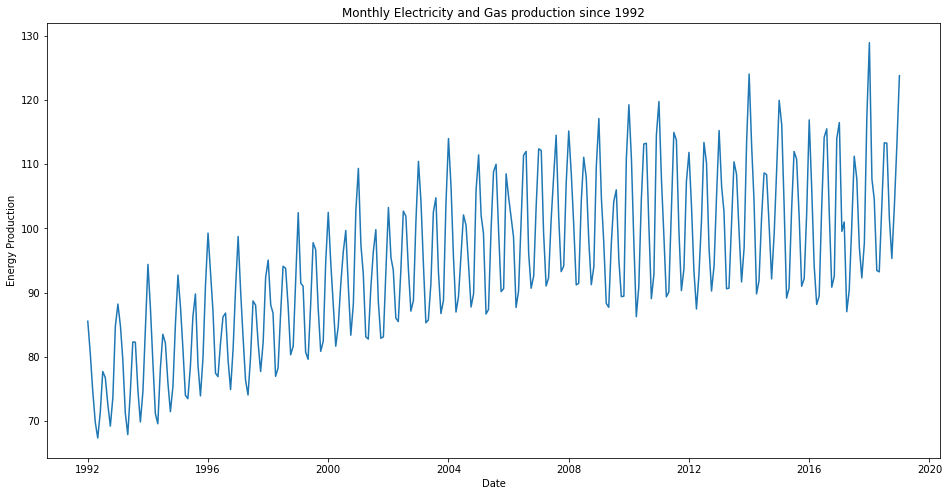

In [19]:
# Plot the data
plt.figure(figsize=(16,8))
plt.plot(df['DATE'], df['IPG2211A2N'])
plt.xlabel('Date')
plt.ylabel('Energy Production')
plt.title('Monthly Electricity and Gas production since 1992')
plt.show()

### Split data

In [37]:
# Energy production vals
y = df['IPG2211A2N'].values

# Test set of 12mo
test_size = 12
train = y[:-test_size]
test = y[-test_size:]
print('Train data before fit:', train[:5])

# Normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train.reshape(-1,1))  # scaler requires 2D vector to fit
train_norm = scaler.transform(train.reshape(-1,1))
train_norm = torch.FloatTensor(train_norm).view(-1)  # flatten out normalized training data
print('Train data after fit:', train_norm[:5])

# Build sequence/prediction data to train model with
window_size = 12
def sequence_data(seq, ws):
    out = []
    for i in range(len(seq)-ws):
        given = seq[i:i+ws]
        pred = seq[i+ws]
        out.append((given,pred))
    return out

train_data = sequence_data(train_norm, window_size)
print('First instance of training data:\n', train_data[0])

Train data before fit: [85.556  80.4178 74.739  69.8367 67.3781]
Train data after fit: tensor([-0.4091, -0.5761, -0.7607, -0.9201, -1.0000])
First instance of training data:
 (tensor([-0.4091, -0.5761, -0.7607, -0.9201, -1.0000, -0.8686, -0.6636, -0.6944,
        -0.8313, -0.9396, -0.7939, -0.4343]), tensor(-0.3223))


### Define model

In [44]:
class LSTMnetwork(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1):
        """
        input_size: 1 sequence of known vals
        hidden_size: 100 neurons in the hidden layer
        output_size: 1 prediction
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.hidden = (torch.zeros(1,1,hidden_size), torch.zeros(1,1,hidden_size))
    
    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1))
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

model = LSTMnetwork()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

### Train the model

In [45]:
epochs = 100

import time
start = time.time()

for epoch in range(epochs):
    for seq,y_train in train_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1,model.hidden_size))
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch+1} \t Loss: {loss.item()}')

elapsed = round(time.time() - start, 0)
print(f'Total time taken to train: {elapsed}')

c:\Users\611391\Documents\Learning\ML Bootcamp\ml_env\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1 	 Loss: 0.30481085181236267
Epoch: 2 	 Loss: 0.30262964963912964
Epoch: 3 	 Loss: 0.3035784661769867
Epoch: 4 	 Loss: 0.30188557505607605
Epoch: 5 	 Loss: 0.29462525248527527
Epoch: 6 	 Loss: 0.2829165756702423
Epoch: 7 	 Loss: 0.26895517110824585
Epoch: 8 	 Loss: 0.2551688253879547
Epoch: 9 	 Loss: 0.24256259202957153
Epoch: 10 	 Loss: 0.2313266545534134
Epoch: 11 	 Loss: 0.22122925519943237
Epoch: 12 	 Loss: 0.21171268820762634
Epoch: 13 	 Loss: 0.20224107801914215
Epoch: 14 	 Loss: 0.19248344004154205
Epoch: 15 	 Loss: 0.1823442131280899
Epoch: 16 	 Loss: 0.172031432390213
Epoch: 17 	 Loss: 0.16200214624404907
Epoch: 18 	 Loss: 0.15274891257286072
Epoch: 19 	 Loss: 0.14461828768253326
Epoch: 20 	 Loss: 0.13773906230926514
Epoch: 21 	 Loss: 0.13206154108047485
Epoch: 22 	 Loss: 0.1274394989013672
Epoch: 23 	 Loss: 0.12367893755435944
Epoch: 24 	 Loss: 0.12058350443840027
Epoch: 25 	 Loss: 0.1180310845375061
Epoch: 26 	 Loss: 0.11597491800785065
Epoch: 27 	 Loss: 0.1144134551

### Compare results to test set

In [68]:
future = 12

preds = list(train_norm[-window_size:])

# Set model to eval mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

print(f'Normalized model preds for final 12 months:\n', preds[-window_size:])

Normalized model preds for final 12 months:
 [0.3251977264881134, 0.20764729380607605, -0.36918357014656067, -0.3217552602291107, 0.03042057529091835, 0.2892796993255615, 0.27400752902030945, 0.06051836162805557, -0.14778345823287964, -0.13058564066886902, 0.1663503646850586, 0.6593035459518433]


In [69]:
# Compare predicted to actual final 12 months
true_preds = scaler.inverse_transform(np.array(preds[-window_size:]).reshape(-1,1))
correct_vals = y[-window_size-1:]
x = np.arange('2018-01-01', '2019-02-01', dtype='datetime64[M]')

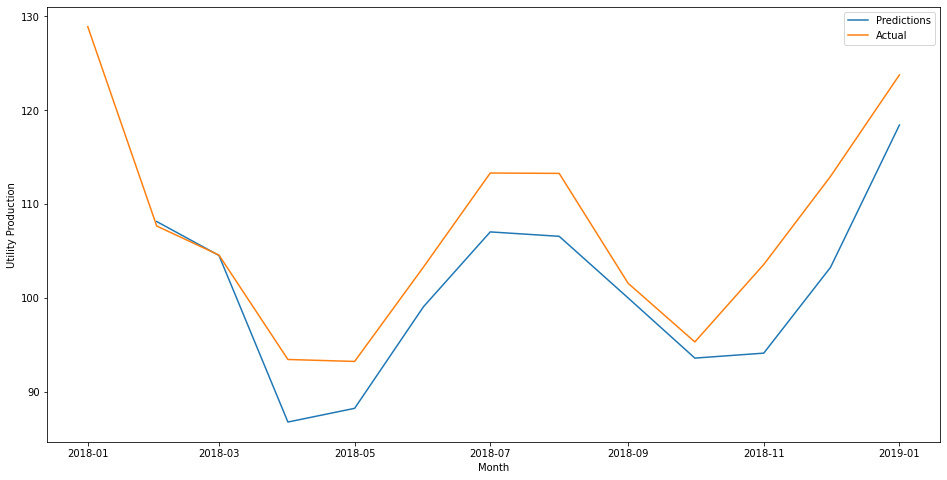

In [70]:
plt.figure(figsize=(16,8))
plt.plot(x[1:], true_preds, label='Predictions')
plt.plot(x, correct_vals, label='Actual')
plt.legend()
plt.xlabel('Month')
plt.ylabel('Utility Production')
plt.show()

### Forecast into the future

In [71]:
# Retrain model on full dataset
epochs = 100

# Model into train mode
model.train()

# Normalize all data
y_norm = scaler.fit_transform(y.reshape(-1,1))
y_norm = torch.FloatTensor(y_norm).view(-1)

all_data = sequence_data(y_norm, window_size)

start = time.time()

for epoch in range(epochs):
    for seq,y_train in all_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1,model.hidden_size))
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch+1} \t Loss: {loss.item()}')

elapsed = round(time.time() - start, 0)
print(f'Total time taken to train: {elapsed}')

c:\Users\611391\Documents\Learning\ML Bootcamp\ml_env\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1 	 Loss: 0.0219527930021286
Epoch: 2 	 Loss: 0.00014685560017824173
Epoch: 3 	 Loss: 0.00010852846753550693
Epoch: 4 	 Loss: 0.007499623112380505
Epoch: 5 	 Loss: 0.004714394919574261
Epoch: 6 	 Loss: 0.0011246084468439221
Epoch: 7 	 Loss: 0.0036553938407450914
Epoch: 8 	 Loss: 0.0055045923218131065
Epoch: 9 	 Loss: 7.240172999445349e-05
Epoch: 10 	 Loss: 6.241752998903394e-05
Epoch: 11 	 Loss: 0.003130580997094512
Epoch: 12 	 Loss: 0.038242701441049576
Epoch: 13 	 Loss: 5.4235151765169576e-05
Epoch: 14 	 Loss: 0.0005633807159028947
Epoch: 15 	 Loss: 0.0047553107142448425
Epoch: 16 	 Loss: 0.005662261974066496
Epoch: 17 	 Loss: 0.006980548612773418
Epoch: 18 	 Loss: 0.0009708265424706042
Epoch: 19 	 Loss: 0.0021474938839673996
Epoch: 20 	 Loss: 3.6906917557644192e-06
Epoch: 21 	 Loss: 0.00030138931469991803
Epoch: 22 	 Loss: 0.0004569874727167189
Epoch: 23 	 Loss: 0.0007618713425472379
Epoch: 24 	 Loss: 3.5059724723396357e-07
Epoch: 25 	 Loss: 0.003004474565386772
Epoch: 26 	 L

In [73]:
# Predict utility production over the next 12mo
future = 12

preds_future = list(y_norm[-window_size:])

# Set model to eval mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds_future[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1,model.hidden_size))
        preds_future.append(model(seq).item())

true_preds = scaler.inverse_transform(np.array(preds[-window_size:]).reshape(-1,1))
print(f'Scaled model preds for next 12 months:\n', true_preds[-window_size:])

Scaled model preds for next 12 months:
 [[108.14714546]
 [104.53076517]
 [ 86.78485206]
 [ 88.2439603 ]
 [ 99.07847379]
 [107.04214531]
 [106.57230463]
 [100.00441714]
 [ 93.5961158 ]
 [ 94.12519806]
 [103.26028579]
 [118.42574394]]


Text(0.5, 1.0, 'Utility Production Forecasts')

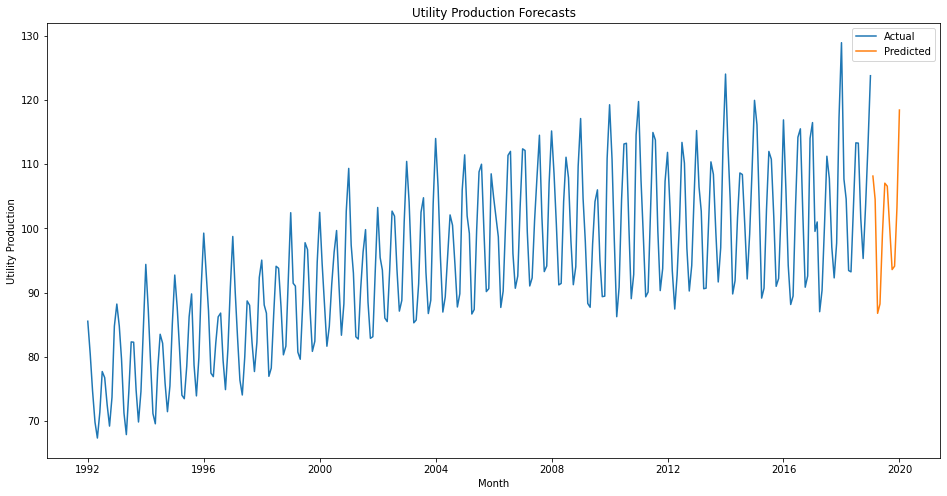

In [76]:
plt.figure(figsize=(16,8))
plt.plot(df['DATE'], y, label='Actual')
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]')
plt.plot(x, true_preds, label='Predicted')
plt.xlabel('Month')
plt.ylabel('Utility Production')
plt.legend()
plt.title('Utility Production Forecasts')

Text(0.5, 1.0, 'Utility Production Forecasts')

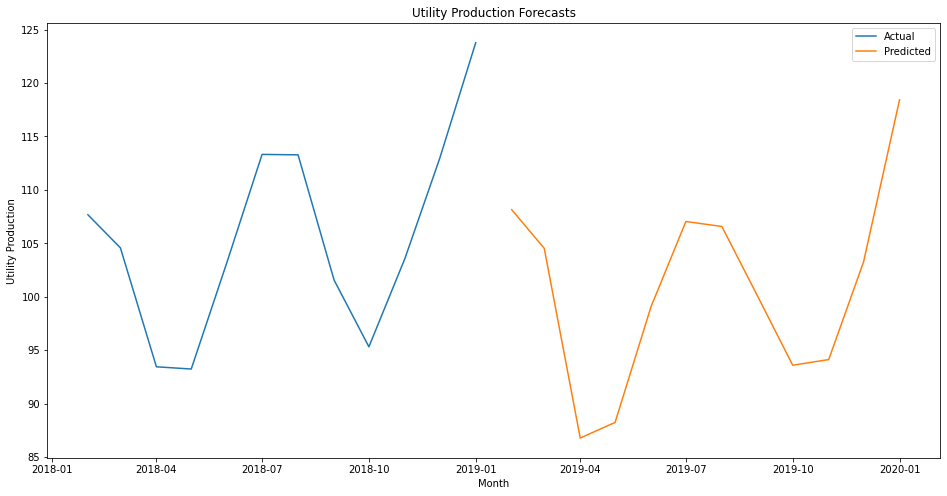

In [80]:
plt.figure(figsize=(16,8))
plt.plot(df[df['DATE'] > '2018-01-01']['DATE'], y[-window_size:], label='Actual')
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]')
plt.plot(x, true_preds, label='Predicted')
plt.xlabel('Month')
plt.ylabel('Utility Production')
plt.legend()
plt.title('Utility Production Forecasts')

Future predictions look pretty good! The same general trend is followed, with peaks and troughs lining up with the previous 12 months. The overall trend for the more recent years appears to be leveling our or even decreasing Utility Production, so it's no surprise that the predicted values are lower than those 1y prior.